**Name:** Carlos Pérez Ricardo

**Date:** 2021-12-06

**Position:** Data-Insights Analyst Adevinta (Motor)

# Data Analysis Task

Task description and data for candidates applying to be a Data Analyst in Adevinta Spain 

## Background

Discovery (and other teams within the Foundation) rely on *event logging* (EL) to track a variety of performance and usage metrics to help us make decisions. Specifically, Discovery is interested in:

- *clickthrough rate*: the proportion of search sessions where the user clicked on one of the results displayed
- *zero results rate*: the proportion of searches that yielded 0 results

and other metrics outside the scope of this task. EL uses JavaScript to asynchronously send messages (events) to our servers when the user has performed specific actions. In this task, you will analyze a subset of our event logs.

## Task

You must create a **reproducible report**\* answering the following questions:

1. What is our daily overall clickthrough rate? How does it vary between the groups?
2. Which results do people tend to try first? How does it change day-to-day?
3. What is our daily overall zero results rate? How does it vary between the groups?
4. Let *session length* be approximately the time between the first event and the last event in a session. Choose a variable from the dataset and describe its relationship to session length. Visualize the relationship.
5. Summarize your findings in an *executive summary*.

\* Given dependencies and other instructions, we should be able to re-run your source code with the dataset in the same directory and obtain the same results and figures. Popular formats for this include RMarkdown and Jupyter Notebook (formerly IPython).

**Note**: if you submit your report as a Jupyter/IPython notebook on Greenhouse, please upload a copy to GitHub and include the link when you submit it on Greenhouse.

## Data

The dataset comes from a [tracking schema](https://meta.wikimedia.org/wiki/Schema:TestSearchSatisfaction2) that we use for assessing user satisfaction. Desktop users are randomly sampled to be anonymously tracked by this schema which uses a "I'm alive" pinging system that we can use to estimate how long our users stay on the pages they visit. The dataset contains just a little more than a week of EL data.

| Column          | Value   | Description                                                                       |
|:----------------|:--------|:----------------------------------------------------------------------------------|
| uuid            | string  | Universally unique identifier (UUID) for backend event handling.                  |
| timestamp       | integer | The date and time (UTC) of the event, formatted as YYYYMMDDhhmmss.                |
| session_id      | string  | A unique ID identifying individual sessions.                                      |
| group           | string  | A label ("a" or "b").                                     |
| action          | string  | Identifies in which the event was created. See below.                             |
| checkin         | integer | How many seconds the page has been open for.                                      |
| page_id         | string  | A unique identifier for correlating page visits and check-ins.                    |
| n_results       | integer | Number of hits returned to the user. Only shown for searchResultPage events.      |
| result_position | integer | The position of the visited page's link on the search engine results page (SERP). |

The following are possible values for an event's action field:

- **searchResultPage**: when a new search is performed and the user is shown a SERP.
- **visitPage**: when the user clicks a link in the results.
- **checkin**: when the user has remained on the page for a pre-specified amount of time.

In [4]:
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import gzip

from statsmodels.stats.weightstats import ztest as ztest
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [5]:
FILENAME = './events_log.csv.gz'

In [6]:
with gzip.open(FILENAME) as f:
    df = pd.read_csv(f)

display(df.head())
display(df.shape)

,uuid,timestamp,session_id,group,action,checkin,page_id,n_results,result_position
0,00000736167c507e8ec225bd9e71f9e5,2.016030e+13,78245c2c3fba013a,b,searchResultPage,NaN,cbeb66d1bc1f1bc2,5.0,NaN
1,00000c69fe345268935463abbfa5d5b3,2.016031e+13,c559c3be98dca8a4,a,searchResultPage,NaN,eb658e8722aad674,10.0,NaN
2,00003bfdab715ee59077a3670331b787,2.016030e+13,760bf89817ce4b08,a,checkin,30.0,f99a9fc1f7fdd21e,NaN,NaN
3,0000465cd7c35ad2bdeafec953e08c1a,2.016030e+13,fb905603d31b2071,a,checkin,60.0,e5626962a6939a75,NaN,10.0
4,000050cbb4ef5b42b16c4d2cf69e6358,2.016030e+13,c2bf5e5172a892dc,a,checkin,30.0,787dd6a4c371cbf9,NaN,NaN


(400165, 9)

In [7]:
df['timestamp'] = df['timestamp'].astype(int)

# timestamp detail
df.iloc[0]['timestamp']

20160301103842

In [8]:
def convert_timestamp(df):
    # timestamp format: YYYYMMDDhhmmss
    # Year(0-4) Month(4-6) Day(6-8)

    df['timestamp_date_str'] = df['timestamp'].apply(lambda x : str(x)[0:4] + '-' + str(x)[4:6] + '-' + str(x)[6:8] )
    df['timestamp_date'] = pd.to_datetime(df['timestamp_date_str'])
    df['timestamp_date'] = df['timestamp_date'].apply( lambda x: x.strftime("%Y-%m-%d"))

    df['timestamp_time'] = df['timestamp'].apply(lambda x : str(x)[8:10] + ':' + str(x)[10:12] + ':' + str(x)[12:14] )
   
    return df

In [9]:
df = convert_timestamp(df)

In [10]:
# Number of unique sessions
df['session_id'].value_counts()

b254341e78af2f1a    484
593638dbb24d903a    305
549c7d24637bc68c    250
4264985570c2b41d    234
b1b9ad0b289027e1    223
                   ... 
662d43d3c7ac38e4      1
6ff29fe830d35dfb      1
8544c946720ee456      1
366c412d3a128684      1
0e162947b4c60720      1
Name: session_id, Length: 68028, dtype: int64

# 1. What is our daily overall clickthrough rate? How does it vary between the groups?

**Clickthrough rate:** the proportion of search sessions where the user clicked on one of the results displayed

In [11]:
df.head(10)

,uuid,timestamp,session_id,group,action,checkin,page_id,n_results,result_position,timestamp_date_str,timestamp_date,timestamp_time
0,00000736167c507e8ec225bd9e71f9e5,20160301103842,78245c2c3fba013a,b,searchResultPage,NaN,cbeb66d1bc1f1bc2,5.0,NaN,2016-03-01,2016-03-01,10:38:42
1,00000c69fe345268935463abbfa5d5b3,20160307005226,c559c3be98dca8a4,a,searchResultPage,NaN,eb658e8722aad674,10.0,NaN,2016-03-07,2016-03-07,00:52:26
2,00003bfdab715ee59077a3670331b787,20160302145305,760bf89817ce4b08,a,checkin,30.0,f99a9fc1f7fdd21e,NaN,NaN,2016-03-02,2016-03-02,14:53:05
3,0000465cd7c35ad2bdeafec953e08c1a,20160302222701,fb905603d31b2071,a,checkin,60.0,e5626962a6939a75,NaN,10.0,2016-03-02,2016-03-02,22:27:01
4,000050cbb4ef5b42b16c4d2cf69e6358,20160302095023,c2bf5e5172a892dc,a,checkin,30.0,787dd6a4c371cbf9,NaN,NaN,2016-03-02,2016-03-02,09:50:23
5,0000a6af2baa5af1be2431e84cb01da1,20160302112945,f6840a9614c527ad,a,checkin,180.0,6fb7b9ea87012975,NaN,NaN,2016-03-02,2016-03-02,11:29:45
6,0000cd61e11d5371adf974703cd4f7e7,20160301055457,51f4d3b6a8688e56,a,checkin,240.0,8ad97e7c85c58e80,NaN,NaN,2016-03-01,2016-03-01,05:54:57
7,000104fe220a5675a270420cd6d4d4ac,20160302012845,485eabe5374f09e4,b,searchResultPage,NaN,4da9a64232ce947b,15.0,NaN,2016-03-02,2016-03-02,01:28:45
8,00012e37b74c59a8911514c894402406,20160303113255,91174a537d79a0c7,a,checkin,180.0,dfdff179047ea086,NaN,1.0,2016-03-03,2016-03-03,11:32:55
9,000145fbe6915c7c8acb3a43537ad048,20160303223353,a795756dbad3f61f,b,checkin,150.0,ec0bad0075f48b43,NaN,1.0,2016-03-03,2016-03-03,22:33:53


In [12]:
# Example of a session
df[df['session_id'] == '51f4d3b6a8688e56'].sort_values('timestamp')

,uuid,timestamp,session_id,group,action,checkin,page_id,n_results,result_position,timestamp_date_str,timestamp_date,timestamp_time
242754,9b152d4193675e18b5a22175aa456c72,20160301054942,51f4d3b6a8688e56,a,searchResultPage,NaN,747a7fab37146fcd,20.0,NaN,2016-03-01,2016-03-01,05:49:42
388098,f82cd39baafe5da098ebe2117f48e2a4,20160301054946,51f4d3b6a8688e56,a,visitPage,NaN,a81cc5e5a5b306e9,NaN,1.0,2016-03-01,2016-03-01,05:49:46
130305,53986cb5a8a35d308115ce84aa0a98d6,20160301054956,51f4d3b6a8688e56,a,checkin,10.0,a81cc5e5a5b306e9,NaN,1.0,2016-03-01,2016-03-01,05:49:56
44980,1ce7ba34e1675b218b729b4633422d15,20160301055006,51f4d3b6a8688e56,a,checkin,20.0,a81cc5e5a5b306e9,NaN,1.0,2016-03-01,2016-03-01,05:50:06
339694,d918790195a5527aa8f345088fb77551,20160301055017,51f4d3b6a8688e56,a,checkin,30.0,a81cc5e5a5b306e9,NaN,1.0,2016-03-01,2016-03-01,05:50:17
1507,00ea13b0e50e522ea0aa3327e93bfa73,20160301055027,51f4d3b6a8688e56,a,checkin,40.0,a81cc5e5a5b306e9,NaN,1.0,2016-03-01,2016-03-01,05:50:27
48870,1f6f9e176b5e56df82a70da5f9ef1583,20160301055036,51f4d3b6a8688e56,a,checkin,50.0,a81cc5e5a5b306e9,NaN,1.0,2016-03-01,2016-03-01,05:50:36
369334,ec3f1df7d04a537783a124f6fcf5d9fe,20160301055047,51f4d3b6a8688e56,a,checkin,60.0,a81cc5e5a5b306e9,NaN,1.0,2016-03-01,2016-03-01,05:50:47
332718,d49ee21858f3587eb485f3b432063ce4,20160301055056,51f4d3b6a8688e56,a,visitPage,NaN,8ad97e7c85c58e80,NaN,NaN,2016-03-01,2016-03-01,05:50:56
155245,6382b160f13e5f308a2a30c02e30d3fc,20160301055106,51f4d3b6a8688e56,a,checkin,10.0,8ad97e7c85c58e80,NaN,NaN,2016-03-01,2016-03-01,05:51:06


In [13]:
# Is there a session_id without visit page?
visit_pages = set(df[ df['action']=='visitPage']['session_id'].unique())
session_ids = set(df['session_id'].unique())

print('Number of sessions:', len(session_ids))
print('Number of sessions without visitPage:',len(session_ids.difference(visit_pages)))

Number of sessions: 68028
Number of sessions without visitPage: 41576


In [14]:
clicks_4_session = df[df['action'] == 'visitPage'][['session_id','timestamp_date','uuid']].groupby(by=['session_id','timestamp_date']).count()
clicks_4_session = clicks_4_session.reset_index()
clicks_4_session.columns = ['session_id','timestamp_date','n_clicks_per_session']
clicks_4_session

,session_id,timestamp_date,n_clicks_per_session
0,0001382e027b2ea4,2016-03-07,1
1,0001e8bb90445cb2,2016-03-05,1
2,00064fe774048046,2016-03-05,1
3,0007b7f6b575feb6,2016-03-03,3
4,000b72561100b509,2016-03-02,1
...,...,...,...
26462,fff73365ad380bc7,2016-03-01,3
26463,fffa1d5e2c608ba6,2016-03-03,1
26464,fffa88acebf831c8,2016-03-04,2
26465,fffb978cc690214c,2016-03-01,1


In [15]:
clicks_per_date = clicks_4_session['timestamp_date'].value_counts()
clicks_per_date

2016-03-07    3747
2016-03-03    3626
2016-03-02    3602
2016-03-01    3524
2016-03-04    3287
2016-03-08    3140
2016-03-06    2968
2016-03-05    2573
Name: timestamp_date, dtype: int64

In [16]:
clicks_per_date = clicks_4_session[['timestamp_date','n_clicks_per_session']].groupby(['timestamp_date']).count()
clicks_per_date

,n_clicks_per_session
timestamp_date,
2016-03-01,3524
2016-03-02,3602
2016-03-03,3626
2016-03-04,3287
2016-03-05,2573
2016-03-06,2968
2016-03-07,3747
2016-03-08,3140


In [17]:
all_sessions_per_date = df[['session_id','timestamp_date']].groupby(by=['timestamp_date']).count()
all_sessions_per_date.columns = ['n_sessions']
all_sessions_per_date

,n_sessions
timestamp_date,
2016-03-01,59324
2016-03-02,60322
2016-03-03,60644
2016-03-04,45746
2016-03-05,36242
2016-03-06,41200
2016-03-07,52558
2016-03-08,44129


In [18]:
click_thru = all_sessions_per_date.join(clicks_per_date, how='left')
# In case there are some days without any click
click_thru['n_clicks_per_session'] = click_thru['n_clicks_per_session'].fillna(0)

click_thru['clickthru_rate'] = click_thru['n_clicks_per_session']/click_thru['n_sessions']*100
click_thru

,n_sessions,n_clicks_per_session,clickthru_rate
timestamp_date,,,
2016-03-01,59324,3524,5.940260
2016-03-02,60322,3602,5.971287
2016-03-03,60644,3626,5.979157
2016-03-04,45746,3287,7.185328
2016-03-05,36242,2573,7.099498
2016-03-06,41200,2968,7.203883
2016-03-07,52558,3747,7.129267
2016-03-08,44129,3140,7.115502


In [19]:
# We create a function to encapsulate previous computations

def click_thru_function(df):
    clicks_4_session = df[df['action'] == 'visitPage'][['session_id','timestamp_date','uuid']].groupby(by=['session_id','timestamp_date']).count()
    clicks_4_session = clicks_4_session.reset_index()
    clicks_4_session.columns = ['session_id','timestamp_date','n_clicks_per_session']
    
    clicks_per_date = clicks_4_session[['timestamp_date','n_clicks_per_session']].groupby(['timestamp_date']).count()

    clicks_per_date.columns = ['session_clicked']

    all_sessions_per_date = df[['session_id','timestamp_date']].groupby(by=['timestamp_date']).count()
    all_sessions_per_date.columns = ['n_sessions']

    click_thru = all_sessions_per_date.join(clicks_per_date, how='left')
    # In case there are some days without any click
    click_thru['session_clicked'] = click_thru['session_clicked'].fillna(0)

    click_thru['clickthru_rate'] = click_thru['session_clicked']/click_thru['n_sessions']*100

    return click_thru 

In [20]:
# Number of groups

groups = list(df['group'].unique())
groups.sort()
print(groups)

['a', 'b']


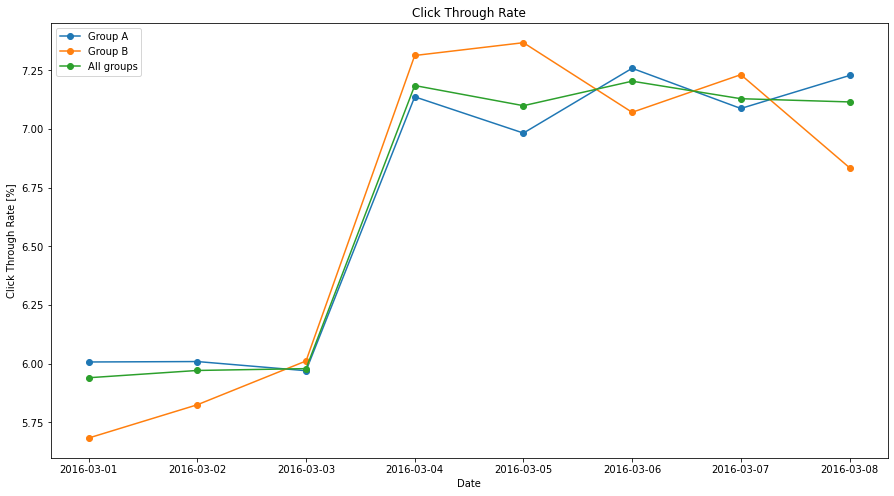

In [21]:
click_thru = click_thru_function(df)

plt.figure(figsize=(15,8))

for group in groups:
    click_thru_grp = click_thru_function(df[df['group'] == group])
    click_thru_grp['clickthru_rate'].plot(marker='o', label='Group '+str.upper(group))

click_thru['clickthru_rate'].plot(marker='o', label='All groups')

plt.xlabel('Date')
plt.ylabel('Click Through Rate [%]')
plt.title('Click Through Rate')
plt.legend()
plt.show()

In [22]:
group_a = click_thru_function(df[df['group'] == 'a'])
group_a.columns = group_a.columns + '_a'

group_b = click_thru_function(df[df['group'] == 'b'])
group_b.columns = group_b.columns + '_b'

all_groups = pd.concat( [ group_a, group_b], axis=1 )
all_groups

,n_sessions_a,session_clicked_a,clickthru_rate_a,n_sessions_b,session_clicked_b,clickthru_rate_b
timestamp_date,,,,,,
2016-03-01,47025,2825,6.007443,12299,699,5.683389
2016-03-02,47876,2877,6.009274,12446,725,5.825165
2016-03-03,47636,2844,5.970275,13008,782,6.011685
2016-03-04,33262,2374,7.137274,12484,913,7.313361
2016-03-05,25262,1764,6.982820,10980,809,7.367942
2016-03-06,29123,2114,7.258868,12077,854,7.071293
2016-03-07,37361,2648,7.087605,15197,1099,7.231690
2016-03-08,31474,2275,7.228188,12655,865,6.835243


A/B testing

In [23]:
print(all_groups['session_clicked_a'].sum() / all_groups['n_sessions_a'].sum()*100)
print(all_groups['session_clicked_b'].sum() / all_groups['n_sessions_b'].sum()*100)

6.595233078834456
6.669566764874538


In [24]:
n_con = all_groups['n_sessions_a'].sum()
n_treat = all_groups['n_sessions_b'].sum()
successes = [all_groups['session_clicked_a'].sum(), all_groups['session_clicked_b'].sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.82
p-value: 0.411
ci 95% for control group: [0.065, 0.067]
ci 95% for treatment group: [0.065, 0.068]


# 2. Which results do people tend to try first? How does it change day-to-day?

In [25]:
# Example of a session
df[df['session_id'] == '51f4d3b6a8688e56'].sort_values('timestamp')

,uuid,timestamp,session_id,group,action,checkin,page_id,n_results,result_position,timestamp_date_str,timestamp_date,timestamp_time
242754,9b152d4193675e18b5a22175aa456c72,20160301054942,51f4d3b6a8688e56,a,searchResultPage,NaN,747a7fab37146fcd,20.0,NaN,2016-03-01,2016-03-01,05:49:42
388098,f82cd39baafe5da098ebe2117f48e2a4,20160301054946,51f4d3b6a8688e56,a,visitPage,NaN,a81cc5e5a5b306e9,NaN,1.0,2016-03-01,2016-03-01,05:49:46
130305,53986cb5a8a35d308115ce84aa0a98d6,20160301054956,51f4d3b6a8688e56,a,checkin,10.0,a81cc5e5a5b306e9,NaN,1.0,2016-03-01,2016-03-01,05:49:56
44980,1ce7ba34e1675b218b729b4633422d15,20160301055006,51f4d3b6a8688e56,a,checkin,20.0,a81cc5e5a5b306e9,NaN,1.0,2016-03-01,2016-03-01,05:50:06
339694,d918790195a5527aa8f345088fb77551,20160301055017,51f4d3b6a8688e56,a,checkin,30.0,a81cc5e5a5b306e9,NaN,1.0,2016-03-01,2016-03-01,05:50:17
1507,00ea13b0e50e522ea0aa3327e93bfa73,20160301055027,51f4d3b6a8688e56,a,checkin,40.0,a81cc5e5a5b306e9,NaN,1.0,2016-03-01,2016-03-01,05:50:27
48870,1f6f9e176b5e56df82a70da5f9ef1583,20160301055036,51f4d3b6a8688e56,a,checkin,50.0,a81cc5e5a5b306e9,NaN,1.0,2016-03-01,2016-03-01,05:50:36
369334,ec3f1df7d04a537783a124f6fcf5d9fe,20160301055047,51f4d3b6a8688e56,a,checkin,60.0,a81cc5e5a5b306e9,NaN,1.0,2016-03-01,2016-03-01,05:50:47
332718,d49ee21858f3587eb485f3b432063ce4,20160301055056,51f4d3b6a8688e56,a,visitPage,NaN,8ad97e7c85c58e80,NaN,NaN,2016-03-01,2016-03-01,05:50:56
155245,6382b160f13e5f308a2a30c02e30d3fc,20160301055106,51f4d3b6a8688e56,a,checkin,10.0,8ad97e7c85c58e80,NaN,NaN,2016-03-01,2016-03-01,05:51:06


In [26]:
display(df['result_position'].describe())
print(np.nanquantile(df['result_position'], 0.8))
print(np.nanquantile(df['result_position'], 0.9))

count    230482.000000
mean          2.992798
std          38.557292
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        4103.000000
Name: result_position, dtype: float64

3.0
5.0


In [27]:
result_positions = df[df['result_position'].isnull() == False]

In [28]:
result_positions = result_positions.sort_values('timestamp').groupby(['session_id']).first()
result_positions = result_positions.reset_index()
result_positions

,session_id,uuid,timestamp,group,action,checkin,page_id,n_results,result_position,timestamp_date_str,timestamp_date,timestamp_time
0,0001382e027b2ea4,cae3f7c7ce5d5d28b4bd6d318d962b1b,20160307084958,b,visitPage,10.0,f88793c95e778898,NaN,1.0,2016-03-07,2016-03-07,08:49:58
1,0001e8bb90445cb2,948f3c30cb585a2db33f61b6c637905e,20160305092430,b,visitPage,10.0,35ee99beb4fb05f0,NaN,1.0,2016-03-05,2016-03-05,09:24:30
2,00064fe774048046,cca28777a66553b78538b6891c4e2d32,20160305074237,a,visitPage,10.0,ea25cebe2f182853,NaN,1.0,2016-03-05,2016-03-05,07:42:37
3,0007b7f6b575feb6,db4529b762a15acc9b88950e7739f603,20160303165632,a,visitPage,10.0,ce7ba13e4b8a6414,NaN,1.0,2016-03-03,2016-03-03,16:56:32
4,000b72561100b509,c14f48a027f65e8884bb89d8303c9d76,20160302172540,b,visitPage,10.0,866e6f24fe7a3e78,NaN,5.0,2016-03-02,2016-03-02,17:25:40
...,...,...,...,...,...,...,...,...,...,...,...,...
26483,fff73365ad380bc7,6865b2a5e8a653cd9c0ccdd7de44289a,20160301224017,a,visitPage,10.0,061e9e5a95499b61,NaN,1.0,2016-03-01,2016-03-01,22:40:17
26484,fffa1d5e2c608ba6,11d310d1bb1c5109a06f4f97cd55442c,20160303212513,a,visitPage,10.0,5f980897ef504ea6,NaN,1.0,2016-03-03,2016-03-03,21:25:13
26485,fffa88acebf831c8,fc5e5c3dff925135a24912d8f0e7dc03,20160304092129,a,visitPage,10.0,6de31b2254c96310,NaN,1.0,2016-03-04,2016-03-04,09:21:29
26486,fffb978cc690214c,f3fdb1871a85593d84ceeeb465939836,20160301150725,b,visitPage,10.0,40b23622fedad58a,NaN,1.0,2016-03-01,2016-03-01,15:07:25


In [29]:
dates = list(df['timestamp_date'].unique())
dates.sort()
dates

['2016-03-01',
 '2016-03-02',
 '2016-03-03',
 '2016-03-04',
 '2016-03-05',
 '2016-03-06',
 '2016-03-07',
 '2016-03-08']

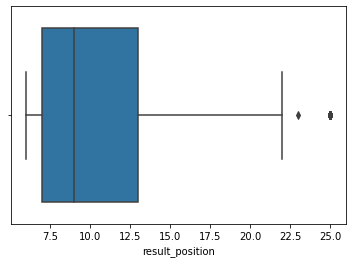

In [30]:
all_days_results_pos = result_positions.copy(deep=True)
all_days_results_pos['result_position'] = np.clip(result_positions['result_position'], a_min = 0, a_max = 25) 
all_days_results_pos =  all_days_results_pos.sort_values('timestamp_date')

ax = sns.boxplot(x = all_days_results_pos[all_days_results_pos['result_position'] > 5]['result_position'] )

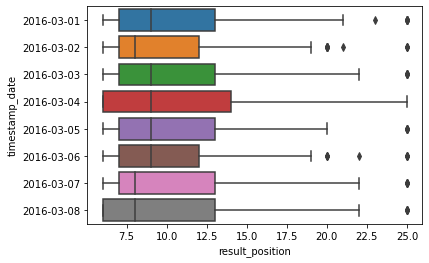

In [31]:
ax = sns.boxplot(data=all_days_results_pos[all_days_results_pos['result_position'] > 5], x = 'result_position', y='timestamp_date')

/Users/carlosperezricardo/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


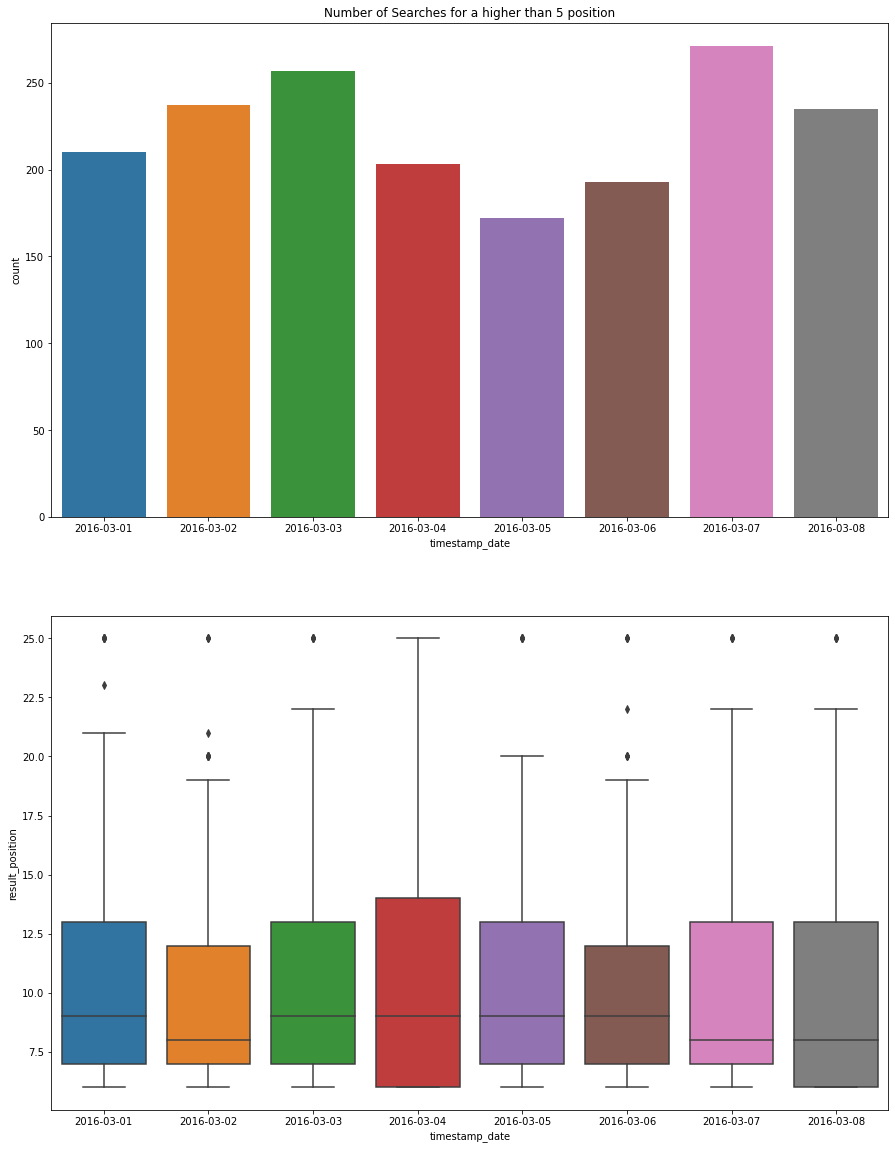

In [32]:
plt.figure(figsize=(15,20))

ax1 = plt.subplot(2,1,1)

ax1 = sns.countplot(
    all_days_results_pos[all_days_results_pos['result_position'] > 5]['timestamp_date']
)
plt.title('Number of Searches for a higher than 5 position')

ax2 = plt.subplot(2,1,2, sharex=ax1)

## Graficamos la distribución del target  
ax2 = sns.boxplot(
    data = all_days_results_pos[all_days_results_pos['result_position'] > 5], 
    x = "timestamp_date",
    y = 'result_position'
)

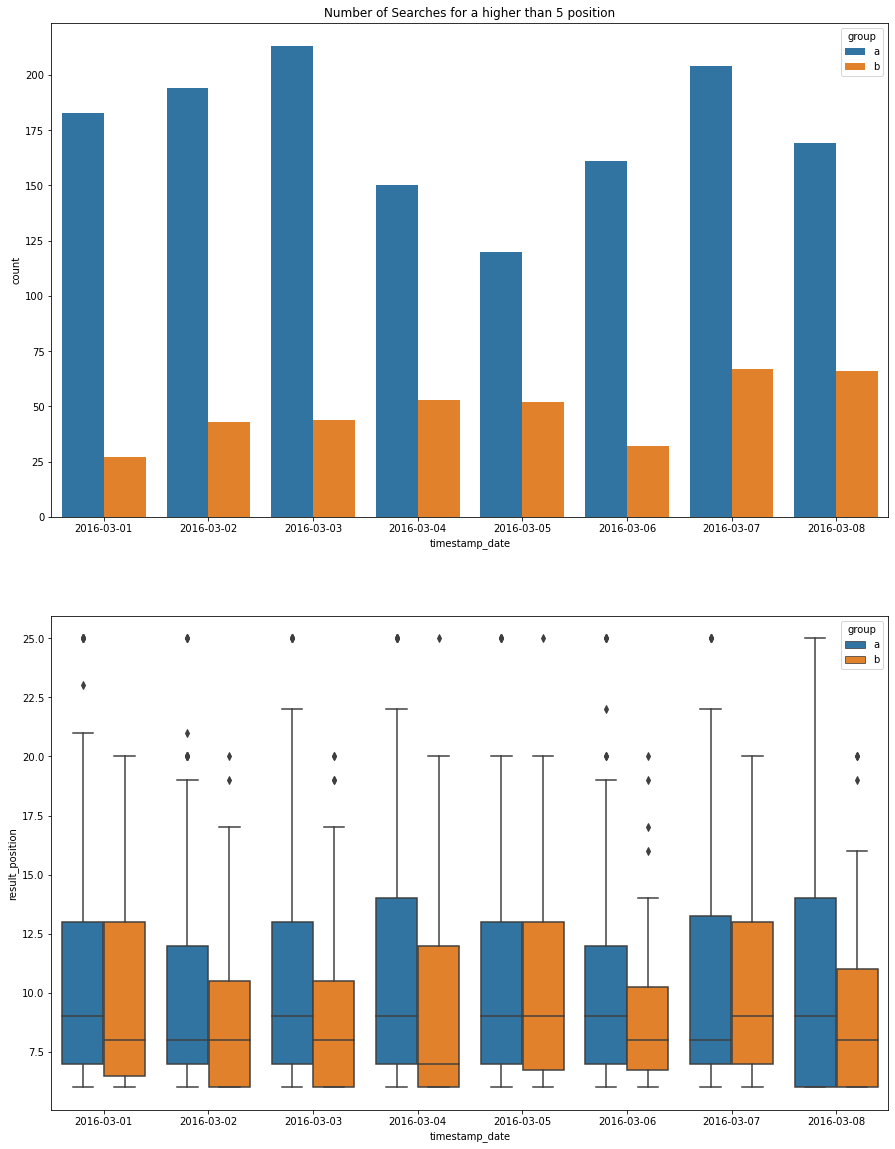

In [33]:
plt.figure(figsize=(15,20))

ax1 = plt.subplot(2,1,1)

ax1 = sns.countplot(
    data = all_days_results_pos[all_days_results_pos['result_position'] > 5],
    x = 'timestamp_date',
    hue = 'group'
)
plt.title('Number of Searches for a higher than 5 position')

ax2 = plt.subplot(2,1,2, sharex=ax1)

## Graficamos la distribución del target  
ax2 = sns.boxplot(
    data = all_days_results_pos[all_days_results_pos['result_position'] > 5], 
    x = "timestamp_date",
    y = 'result_position',
    hue = 'group'
)

# 3. What is our daily overall zero results rate? How does it vary between the groups?

**zero results rate:** the proportion of searches that yielded 0 results

In [34]:
def zero_results_rate(df):
    zero_results_per_date = df[df['n_results'] == 0][['timestamp_date','uuid']].groupby(by=['timestamp_date']).count()
    #zero_results_per_date = zero_results_per_date.reset_index()
    zero_results_per_date.columns = ['no_results']

    all_sessions_per_date = df[['session_id','timestamp_date']].groupby(by=['timestamp_date']).count()
    all_sessions_per_date.columns = ['n_sessions']

    zero_results = all_sessions_per_date.join(zero_results_per_date, how='left')
    # In case there are some days without any click
    zero_results['no_results'] = zero_results['no_results'].fillna(0)

    zero_results['zero_results_rate'] = zero_results['no_results']/zero_results['n_sessions']*100

    return zero_results

In [35]:
zero_results_rate(df)

,n_sessions,no_results,zero_results_rate
timestamp_date,,,
2016-03-01,59324,3447,5.810465
2016-03-02,60322,3589,5.949736
2016-03-03,60644,3443,5.677396
2016-03-04,45746,3015,6.590740
2016-03-05,36242,2442,6.738039
2016-03-06,41200,2574,6.247573
2016-03-07,52558,3460,6.583203
2016-03-08,44129,3157,7.154026


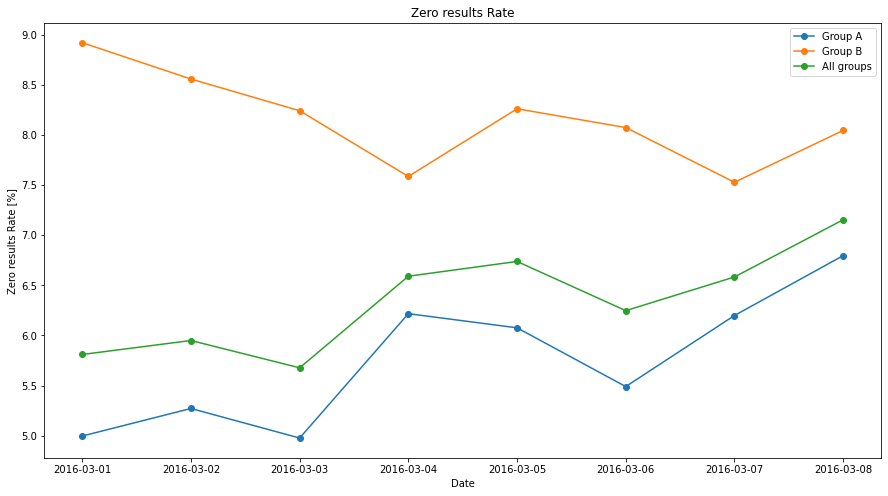

In [36]:
zero_rate = zero_results_rate(df)

plt.figure(figsize=(15,8))

for group in groups:
  zero_rate_grp = zero_results_rate(df[df['group'] == group])
  zero_rate_grp['zero_results_rate'].plot(marker='o', label='Group '+str.upper(group))

zero_rate['zero_results_rate'].plot(marker='o', label='All groups')

plt.xlabel('Date')
plt.ylabel('Zero results Rate [%]')
plt.title('Zero results Rate')
plt.legend()
plt.show()

In [37]:
group_a = zero_results_rate(df[df['group'] == 'a'])
group_a.columns = group_a.columns + '_a'

group_b = zero_results_rate(df[df['group'] == 'b'])
group_b.columns = group_b.columns + '_b'

all_groups = pd.concat( [ group_a, group_b], axis=1 )
all_groups

,n_sessions_a,no_results_a,zero_results_rate_a,n_sessions_b,no_results_b,zero_results_rate_b
timestamp_date,,,,,,
2016-03-01,47025,2350,4.997342,12299,1097,8.919424
2016-03-02,47876,2524,5.271953,12446,1065,8.556966
2016-03-03,47636,2371,4.977328,13008,1072,8.241082
2016-03-04,33262,2068,6.217305,12484,947,7.585710
2016-03-05,25262,1535,6.076320,10980,907,8.260474
2016-03-06,29123,1599,5.490506,12077,975,8.073197
2016-03-07,37361,2316,6.198978,15197,1144,7.527802
2016-03-08,31474,2139,6.796086,12655,1018,8.044251


In [38]:
print(all_groups['no_results_a'].sum() / all_groups['n_sessions_a'].sum()*100)
print(all_groups['no_results_b'].sum() / all_groups['n_sessions_b'].sum()*100)

5.652483621442116
8.131809463547743


A/B testing

In [39]:
n_con = all_groups['n_sessions_a'].sum()
n_treat = all_groups['n_sessions_b'].sum()
successes = [all_groups['no_results_a'].sum(), all_groups['no_results_b'].sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -28.10
p-value: 0.000
ci 95% for control group: [0.056, 0.057]
ci 95% for treatment group: [0.080, 0.083]


# 4. Let session length be approximately the time between the first event and the last event in a session. Choose a variable from the dataset and describe its relationship to session length. Visualize the relationship.

In [40]:
select_cols = ['session_id', 'timestamp', 'group', 'page_id']
session_lengths = df[select_cols].sort_values('timestamp').groupby('session_id').agg(['first', 'last'])
session_lengths.columns = ['ts_first','ts_last','group','group_','page_id','page_id_']
session_lengths = session_lengths[['ts_first','ts_last','group','page_id']]

session_lengths['duration'] = session_lengths['ts_last'] -  session_lengths['ts_first']

# Clean results with 0 durations
session_lengths = session_lengths[ session_lengths['duration'] != 0 ] 

session_lengths['timestamp'] = session_lengths['ts_first']
session_lengths = convert_timestamp(session_lengths)

session_lengths

,ts_first,ts_last,group,page_id,duration,timestamp,timestamp_date_str,timestamp_date,timestamp_time
session_id,,,,,,,,,
0001382e027b2ea4,20160307084955,20160307085458,b,7aa28c36c03380a0,503,20160307084955,2016-03-07,2016-03-07,08:49:55
0001e8bb90445cb2,20160305092415,20160305093130,b,6b7f8832f5b6cc7d,715,20160305092415,2016-03-05,2016-03-05,09:24:15
000216cf18ae1ab1,20160308161946,20160308162044,a,08cebdafafbe069a,98,20160308161946,2016-03-08,2016-03-08,16:19:46
00064fe774048046,20160305074204,20160305074247,a,b3209791cd5e4e9b,43,20160305074204,2016-03-05,2016-03-05,07:42:04
0007b7f6b575feb6,20160303165629,20160303170208,a,dcb04d5e7a4afca7,4579,20160303165629,2016-03-03,2016-03-03,16:56:29
...,...,...,...,...,...,...,...,...,...
fff73365ad380bc7,20160301224010,20160301224228,a,ea76f549e8ff1df4,218,20160301224010,2016-03-01,2016-03-01,22:40:10
fffa1d5e2c608ba6,20160303212455,20160303212553,a,d476178def4c7a1a,98,20160303212455,2016-03-03,2016-03-03,21:24:55
fffa88acebf831c8,20160304092118,20160304092844,a,a5dd14191eaeb687,726,20160304092118,2016-03-04,2016-03-04,09:21:18


In [41]:
session_lengths['duration'].describe()

count    4.042200e+04
mean     2.329658e+03
std      4.635606e+04
min      1.000000e+00
25%      4.800000e+01
50%      1.620000e+02
75%      6.930000e+02
max      5.965439e+06
Name: duration, dtype: float64

In [42]:
session_lengths[ session_lengths['group'] == 'a']['duration'].describe()

count    2.942700e+04
mean     2.500724e+03
std      5.028623e+04
min      1.000000e+00
25%      6.400000e+01
50%      1.980000e+02
75%      7.060000e+02
max      5.965439e+06
Name: duration, dtype: float64

In [43]:
session_lengths[ session_lengths['group'] == 'b']['duration'].describe()

count     10995.000000
mean       1871.816462
std       33647.918400
min           1.000000
25%          18.000000
50%          90.000000
75%         407.000000
max      958199.000000
Name: duration, dtype: float64

In [44]:
session_lengths['duration'] = np.clip(session_lengths['duration'], \
                                      a_min = 0, a_max=np.quantile(session_lengths['duration'], 0.9))

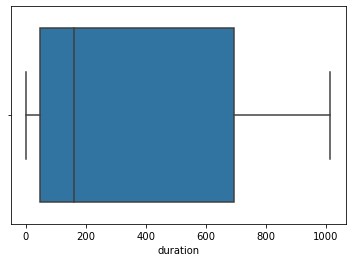

In [45]:
ax = sns.boxplot(x=session_lengths["duration"])

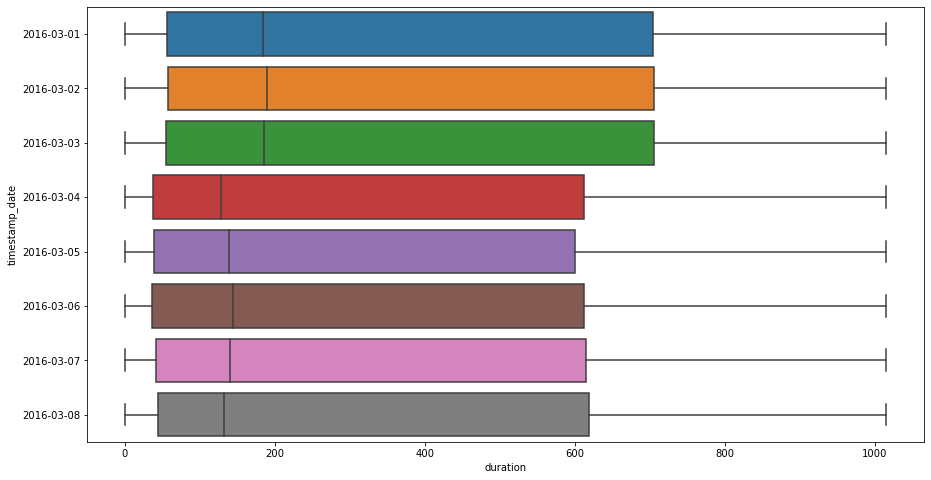

In [46]:
session_lengths = session_lengths.sort_values('timestamp_date')

plt.figure(figsize=(15,8))
ax = sns.boxplot(data=session_lengths, x="duration", y="timestamp_date")

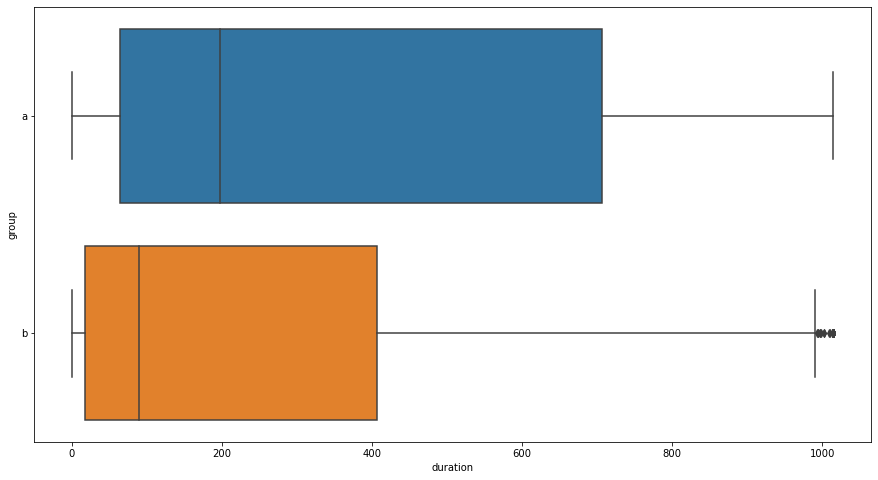

In [47]:
plt.figure(figsize=(15,8))
ax = sns.boxplot(data=session_lengths, x="duration", y="group")

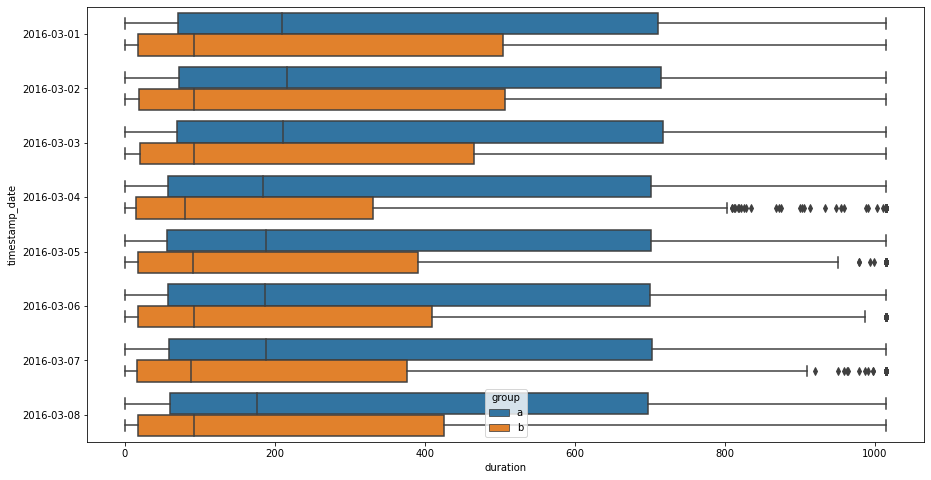

In [48]:
plt.figure(figsize=(15,8))
ax = sns.boxplot(data=session_lengths, x="duration", y='timestamp_date', hue="group")

# 5. Summarize your findings in an executive summary.

After conducting an analysis to the following dataset, the following statements can be considered:
- Even though it seeems that Group B has achieved a higher click through rate compared to group A in several days (A: 6.595%, B: 6.700%), the A/B testing performed indicates that there wasn't a meaningful difference in conversion. However, **Group B has led to a much higher number zero results** (as the perfomed test indicates) which is counterproductive (A: 5.652%, B: 8.132%)

- **Users tend to look for the first 3 results** (mostly they opt for the first one). For that reason the aim of the analysis was to look for sessions where the result position is abnormal (it is to be said result position is higher than position 5). Most of the days show a similar distribution.

- In order to perform a further analysis **it would be advisable to encode pages with the same id across days.** So, we could identify which pages users tend to click first. In the giving dataset, there are different page_id for each day, so it is hard to see which page do users tend to click first across different days.

- Finally, **it has been observed that users in group A tend to spend longer in our website.** Users in A spent between 24 and 706 seconds (198 seconds being the median) whereas users in B spent between 18 and 407 seconds (90 seconds being the median). Note: We don't use the mean for metric "time spent" because there are outliers, we rather opt for quartiles and median.

Overall, **Group B hasn't led to better results.** Users in group A have encountered less zero results and have spent more time in our app/website (if spending more time in the website is a positive trait). Even though, Group B has achieved a raise of 2% conversion, the A/B test performed shows that these results are by chance and are not statiscally significant.

